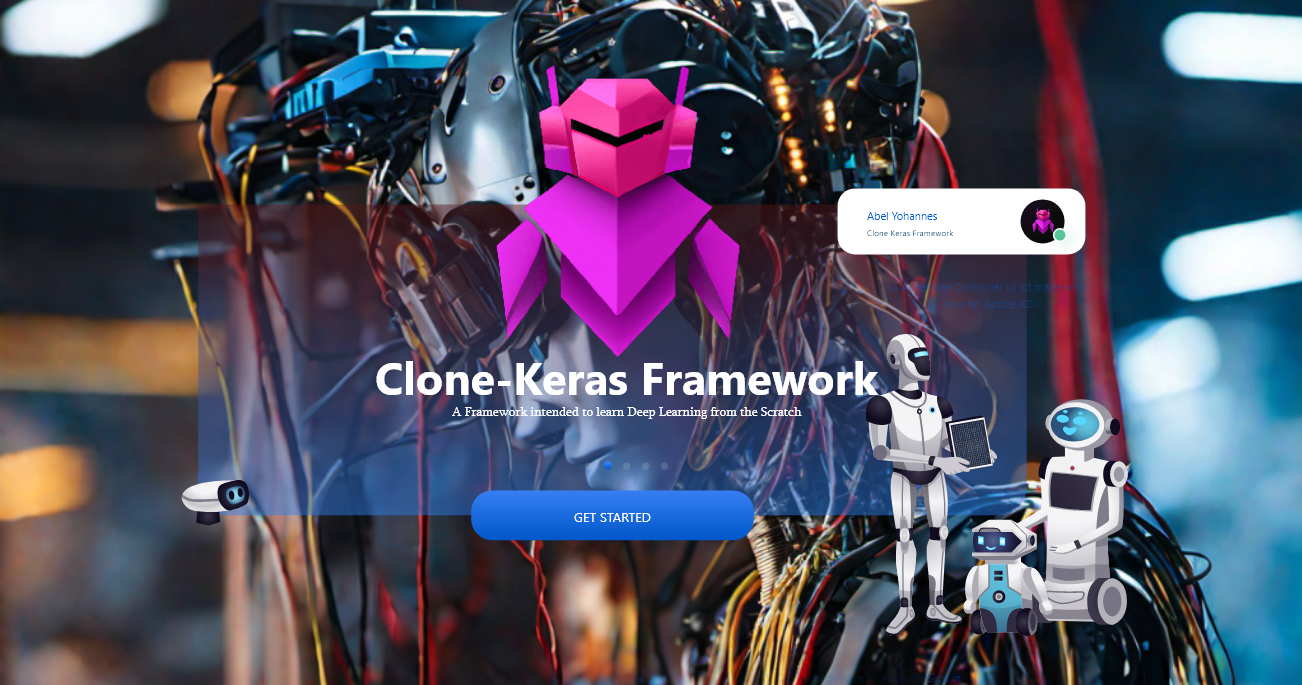

Hello , This is Keras Clone, welcome. This notebook can help you learn and make you a backprop ninja if you are new to it. It will describe the operation of backprop and construct a little version of the technology that resembles the Python API. Andrej Karpathy, an expert in computers, served as its inspiration. You will develop your ninja skills as you practice more. You won't ever view things as a "black box" after reading this notebook's explanation of how high level frameworks work and low level operations.

This is the second notebook that can depict Backprop Engine.

The derivative of a function represents the rate at which the function's value changes with respect to its input variable. Geometrically, it corresponds to the slope of the tangent line to the function's graph at a specific point.

\begin{equation*}
f'(x) = \lim_{{h \to 0}} \frac{{f(x + h) - f(x)}}{h}
\end{equation*}

In [ ]:
!sudo apt-get install graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
pkg-config is already the newest version (0.29.2-1ubuntu3).
graphviz is already the newest version (2.42.2-6).
libgraphviz-dev is already the newest version (2.42.2-6).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
  Using cached pygraphviz-1.11.zip (120 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for pygraphviz: filename=pygraphviz-1.11-cp310-cp310-linux_x86_64.whl size=175927 sha256=f606687a96d7bc7a2c8530a1b170e901f7c8f182b9b5e0e9ba25a20eb9dd10c0
  Stored in directory: /root/.cache/pip/wheels/5b/ee/36/f47a0d35664fbe1a2b5a433ae33c6ad636b00bb231f68a9aaa
Successfully built pygraphviz


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

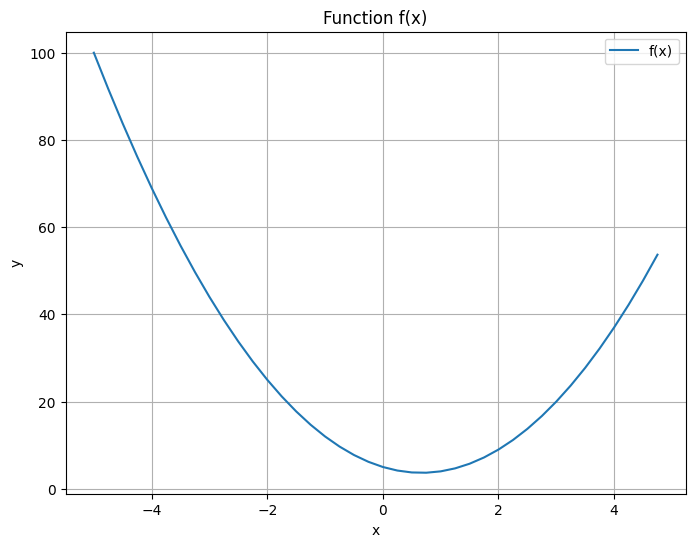

In [ ]:
def f(x):
  return 3*x**2 - 4*x + 5

xs = np.arange(-5, 5, 0.25)
ys = f(xs)

# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.plot(xs, ys, label="f(x)")
plt.xlabel('x')
plt.ylabel('y')
plt.title("Function f(x)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
h = 0.000001
x = 3
(f(x + h) - f(x))/h

14.000003002223593

## Let's Make Complex This more
Certainly! To calculate the partial derivatives of the equation ***(Z = xy + c)***, we can use the following notation:

\begin{equation*}
\frac{{\partial Z}}{{\partial x}}, \quad \frac{{\partial Z}}{{\partial y}}, \quad \frac{{\partial Z}}{{\partial c}}
\end{equation*}

Here are the calculations for each partial derivative:

\begin{equation*}
\frac{{\partial Z}}{{\partial x}} = y, \quad \frac{{\partial Z}}{{\partial y}} = a, \quad \frac{{\partial Z}}{{\partial c}} = 1
\end{equation*}

These partial derivatives represent the rate of change of ***(Z)*** with respect to each variable independently.

In [ ]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## Data class
The Data class in the provided code is a fundamental building block for creating a computational graph and performing automatic differentiation. It represents a node in the graph that holds a numerical value and supports mathematical operations.

Each `Data` instance, or node, holds a numerical value (`data`) and **keeps track of
its children nodes (`_children`)**. The children nodes represent the dependencies of
the current node in the computational graph.

For example, when performing addition (`__add__`) or multiplication (`__mul__`)
between two `Data` instances, the resulting node becomes the parent of the original nodes,
and the original nodes are added to its children.

During the forward pass, the computational graph is evaluated, and the numerical values
flow from input nodes to output nodes based on the defined operations. During the backward pass,
gradients are computed and accumulated in each node using backpropagation,
enabling the calculation of gradients with respect to the input nodes.

In summary, in the provided code, a "node" refers to an instance of the `Data` class, representing a node in the computational graph, which holds a numerical value and keeps track of its dependencies (children nodes) in the graph.

In [ ]:
import math

class Data:

    def __init__(self, data, _children=(), _op='', label=''):
        # Initialize a Data instance with a numerical value, children nodes, operation, and label
        self.data = data
        self._children = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0  # Gradient associated with this node
        # a "node" refers to an instance of the `Data` class.
        # Each `Data` instance represents a node in the computational graph.
        #

    def __repr__(self):
        return f"Data(data={self.data})"

    def __add__(self, other):
        # Overload the '+' operator to perform addition between Data instances
        out = Data(self.data + other.data, (self, other), '+')

        def _backward():
            # Backpropagation: Accumulate gradients for addition operation
            self.grad += out.grad
            other.grad += out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        # Overload the '*' operator to perform multiplication between Data instances
        out = Data(self.data * other.data, (self, other), '*')

        def _backward():
            # Backpropagation: Accumulate gradients for multiplication operation
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        # Apply the hyperbolic tangent activation function to the node's value
        t = (math.exp(2 * self.data) - 1) / (math.exp(2 * self.data) + 1)
        out = Data(t, (self,), 'tanh')

        def _backward():
            # Backpropagation: Accumulate gradients for the tanh operation
            self.grad += (1 - t ** 2) * out.grad

        out._backward = _backward
        return out

    @staticmethod
    def backward(output):
        # Perform backward propagation to compute gradients
        output.grad = 1.0  # Set the gradient of the output node to 1.0
        seen = set()  # Set to keep track of visited nodes during backward propagation
        stack = [output]  # Stack to store nodes for traversal

        while stack:
            node = stack.pop()
            if node not in seen:
                seen.add(node)  # Mark the node as visited
                stack.extend(node._children)  # Add children nodes to the stack for traversal
                node._backward()  # Call the _backward method of the node to accumulate gradients


    def _backward(self):
        # Accumulate gradients for child nodes during backward propagation
        for child in self._children:
            child.grad += self.grad


## Visualize Computational graph

A computational graph is defined as a directed graph where the nodes correspond to mathematical operations. Computational graphs are a way of expressing and evaluating a mathematical expression

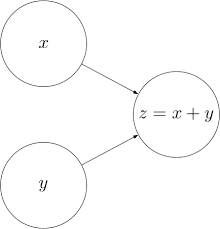

## Easy Visualization Method using graphviz
The visualize_computational_graph function in the provided code is responsible for creating a graphical representation of a computational graph. Here's a breakdown of what the function does:

*   It takes a data parameter, which represents the root node of the computational graph that needs to be visualized.

*   Inside the function, a new graphviz.Digraph object named dot is created. This object will store the nodes and edges of the graph.

*  The function uses a depth-first traversal algorithm to visit each node in the computational graph. It starts with the data node and explores its children in a depth-first manner.

*  The stack is used to keep track of the nodes to be visited. The function initializes the stack with the data node.

*  The visited set is used to track the nodes that have already been visited. This prevents revisiting the same node multiple times and helps avoid infinite loops in cyclic graphs.

*   The function enters a while loop that continues until the stack is empty, indicating that all nodes have been visited.

*   
Within each iteration of the loop, the function pops the top node from the stack using stack.pop().

*   If the node has not been visited before, it is added to the visited set, and its label is generated based on its label and _op attributes.

*   The node is then added to the dot graph using dot.node(), with its ID and label.

*   The function iterates over the children of the current node using a for loop.For each child, an edge is added from the child node to the current node in the dot graph using dot.edge().

Finally, the child node is added to the stack for further traversal.

Once the traversal is complete and all nodes have been visited, the resulting graph is displayed using display(graphviz.Source(dot.source)).


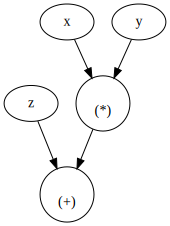

In [ ]:
import graphviz
from IPython.display import display

def visualize_computational_graph(data):
    dot = graphviz.Digraph() # Create a new graph

    stack = [data] # Initialize the stack with the starting node
    visited = set() # Set to track visited nodes

    while stack:
        node = stack.pop() # Pop the top node from the stack
        if node not in visited: # Check if the node has not been visited
            visited.add(node) # Add the node to the visited set
            label = f"{node.label}\n({node._op})" if node._op else node.label   # Generate the label for the node
            dot.node(str(id(node)), label=label)  # Add the node to the graph with its label
            for child in node._children:  # Iterate over the children of the node
                dot.edge(str(id(child)), str(id(node))) # Add an edge from the child to the node
                stack.append(child) # Push the child node to the stack for further traversal

    display(graphviz.Source(dot.source))

# Create an example computational graph
x = Data(2, label='x')
y = Data(3, label='y')
c = Data(4, label='z')
z = x * y + c

# Visualize the computational graph
visualize_computational_graph(b)

In [ ]:
import networkx as nx
import pygraphviz as pgv
from PIL import Image as PilImage
import numpy as np
import io
from IPython.display import Image as IpyImage


def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._children:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

In [ ]:
def trace(root):
    """
          Builds a set of all nodes and edges in a graph by performing a depth-first traversal.
          Args:
              root: The root node of the computational graph.
          Returns:
              nodes: Set of nodes in the graph.
              edges: Set of edges in the graph.
    """
    nodes, edges = set(), set() # Initialize empty sets for nodes and edges

    def build(v):
        """
            Recursive helper function to build the set of nodes and edges in a graph.
            Args:
                v: Current node being visited.
       """
        if v not in nodes:  # Check if the node has not been added to the set of nodes
            nodes.add(v)  # Add the node to the set of nodes
            for child in v._children:  # Iterate over the children of the current node
                edges.add((child, v))  # Add an edge from the child to the current node
                build(child) # Recursively build the graph for the child node

    build(root) # Start building the graph from the root node
    return nodes, edges # Return the set of nodes and edges of the graph


def visualize_computational_graph(output_node):
    """
    Creates a graphical representation of a computational graph.
    Args:
        output_node: The output node of the computational graph.
    Returns:
        viz1_array: Array representation of the rendered graph.
    """
    dot = nx.DiGraph(format='png', graph_attr={'rankdir': 'LR', 'bgcolor': 'transparent'})  # LR = left to right
    nodes, edges = trace(output_node)
    node_mapping = {}  # Mapping of string IDs to node objects

    # Add nodes to the graph
    for n in nodes:
        uid = str(id(n))
        node_mapping[uid] = n  # Store the mapping of ID to node object
        label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad)
        dot.add_node(uid, label=label, shape='record', fontname='Arial', fontsize=10, style='filled',
                     fillcolor='lightblue', color='black')
        if n._op:
            op_uid = uid + n._op
            node_mapping[op_uid] = n  # Store the mapping of ID with operation name to node object
            dot.add_node(op_uid, label=n._op, fontname='Arial', fontsize=10, shape='box', style='filled',
                         fillcolor='lightgray')
            dot.add_edge(op_uid, uid)

    # Add edges to the graph
    for n1, n2 in edges:
        dot.add_edge(str(id(n1)), str(id(n2)) + n2._op)

    pos = nx.spring_layout(dot, seed=42)  # Horizontal layout
    labels = {n: "{:.4f}".format(node_mapping[n].data) for n in dot.nodes()}
    edge_labels = {(u, v): labels[v] for u, v in dot.edges()}

    # Create a PyGraphviz graph from NetworkX graph
    pgv_graph = nx.nx_agraph.to_agraph(dot)

    # Set visual attributes for the graph nodes and edges
    pgv_graph.graph_attr.update({'splines': 'polyline'})
    pgv_graph.node_attr.update({'shape': 'box', 'style': 'filled', 'fillcolor': 'lightgray', 'fontname': 'Arial',
                                'fontsize': 10, 'color': 'black'})
    pgv_graph.edge_attr.update({'fontsize': 8})

    # Render the graph to a file (e.g., in PNG format)
    output_file = "computational_graph.png"
    pgv_graph.draw(output_file, prog="dot", format="png")

    # Convert the rendered graph image to an array
    img = IpyImage(filename=output_file)
    viz1_array = np.array(PilImage.open(io.BytesIO(img.data)))

    # Return the array representation of the rendered graph
    return viz1_array

In [ ]:
def concatenate_images(image1, image2, axis='horizontal'):
    """
    Concatenates two NumPy images either horizontally or vertically.

    Parameters:
        image1 (numpy.ndarray): First image as a NumPy array.
        image2 (numpy.ndarray): Second image as a NumPy array.
        axis (str, optional): Concatenation axis. 'horizontal' for horizontal concatenation,
                              'vertical' for vertical concatenation. Defaults to 'horizontal'.

    Returns:
        numpy.ndarray: Concatenated image as a NumPy array.
    """
    if axis == 'horizontal':
        return np.concatenate((image1, image2), axis=1)
    elif axis == 'vertical':
        return np.concatenate((image1, image2), axis=0)
    else:
        raise ValueError("Invalid axis parameter. Please use 'horizontal' or 'vertical'.")

## Let's Make visualized previous equation
Certainly! To calculate the partial derivatives of the equation ***(Z = xy + c)***, we can use the following notation:

\begin{equation*}
\frac{{\partial Z}}{{\partial x}}, \quad \frac{{\partial Z}}{{\partial y}}, \quad \frac{{\partial Z}}{{\partial c}}
\end{equation*}

Remember the calculations for each partial derivative:

\begin{equation*}
\frac{{\partial Z}}{{\partial x}} = y, \quad \frac{{\partial Z}}{{\partial y}} = x, \quad \frac{{\partial Z}}{{\partial c}} = 1
\end{equation*}

What do you thing of we measure rate of change of **Z** by z ?

\begin{equation*}
\frac{{\partial Z}}{{\partial z}} = \quad ?
\end{equation*}


These partial derivatives represent the rate of change of ***(Z)*** with respect to each variable independently.

Gradient of x before backpropagation : 0.0
Gradient of x after back propagation: 2.0


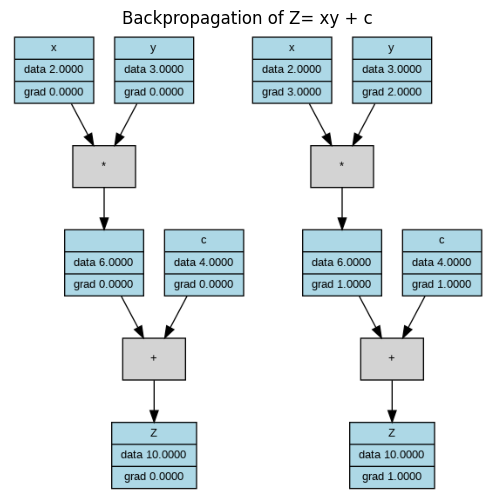

In [ ]:
# Create an example computational graph
x = Data(2, label='x')
y = Data(3, label='y')
c = Data(4, label='c')
Z = x * y + c
Z.label = "Z"
print(f"Gradient of x before backpropagation : {x.grad}")
viz1 = visualize_computational_graph(Z) # visualized initial graph of all object
# Perform backward propagation
Data.backward(Z)
viz2 = visualize_computational_graph(Z) # visualized final grad of all object
print(f"Gradient of x after back propagation: {y.grad}")

# Concatenate the images horizontally
concatenated_image = concatenate_images(viz1, viz2, axis='horizontal')


# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.title("Backpropagation of Z= xy + c")
plt.axis('off')
plt.imshow(concatenated_image)
plt.show()

## Let's Try another equation

In [ ]:
a = Data(2.0, label='a')
b = Data(-3.0, label='b')
c = Data(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Data(-2.0, label='f')
L = d * f; L.label = 'L'
L

Data(data=-8.0)

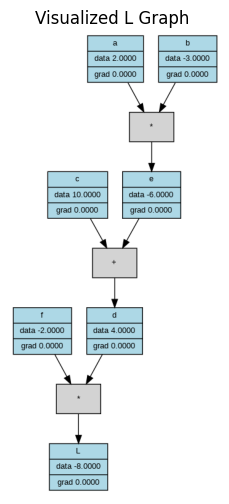

In [ ]:
# visualized L graph now
viz_L = visualize_computational_graph(L)
# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.title("Visualized L Graph ")
plt.axis('off')
plt.imshow(viz_L)
plt.show()

## Do some Gradient Descent

In [ ]:
Data.backward(L)
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data) # From (-8) ==> -7.2

-7.286496


## Activation Function
An activation function, in the context of neural networks and deep learning, is a mathematical function that introduces non-linearity into the network's output. It is applied to the output of a neuron or a layer of neurons, transforming the input signal into an output signal.

Activation functions play a crucial role in neural networks by enabling the network to learn complex patterns and make non-linear decisions. They introduce non-linear properties to the network, allowing it to approximate and represent non-linear relationships between inputs and outputs.
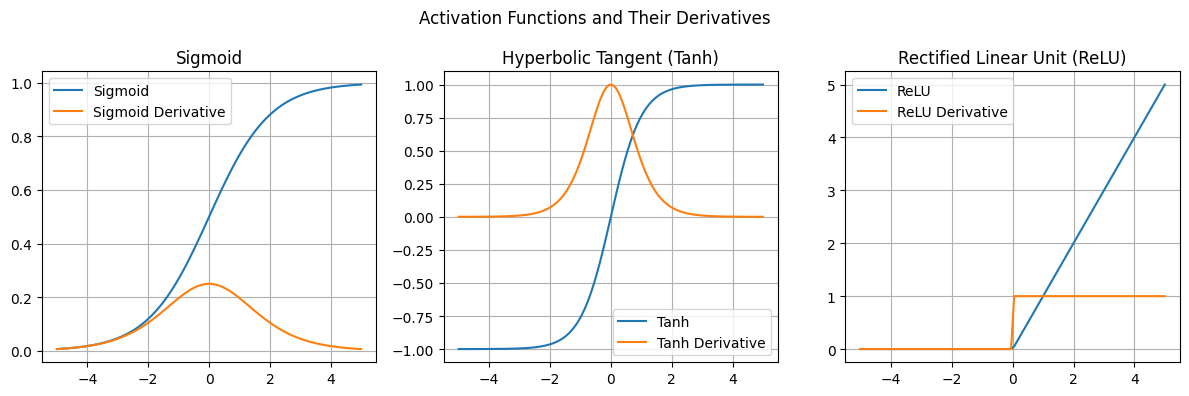



Commonly used activation functions is like tanh :

The hyperbolic tangent function, commonly known as tanh, is another commonly used activation function in neural networks. It is a rescaled version of the sigmoid function and produces values between -1 and 1. The tanh function is defined as:

\begin{equation*}
f(x) = \frac{{e^x - e^{-x}}}{{e^x + e^{-x}}}
\end{equation*}

The tanh activation function exhibits similar properties to the sigmoid function but with a symmetric range. It is centered around 0, where negative inputs are mapped close to -1 and positive inputs close to 1. The function is continuous and differentiable across its entire range.

The tanh activation function is useful in neural networks for various reasons:

    Non-linearity: Tanh introduces non-linearity, allowing the network to learn and represent
    complex patterns and relationships in the data.

    Gradient preservation: Tanh has a steeper gradient than the sigmoid function, especially around the origin.
    This property can help alleviate the vanishing gradient problem to some extent.

    Zero-centered output: Unlike the sigmoid function, the tanh function produces zero-centered outputs,
    which can be beneficial for the optimization process during training.

Tanh is often used in recurrent neural networks (RNNs) and some hidden layers of feed-forward neural networks. However, it is important to note that the choice of activation function depends on the specific problem, network architecture, and the desired properties of the network's outputs. Different activation functions may be more suitable for different scenarios.

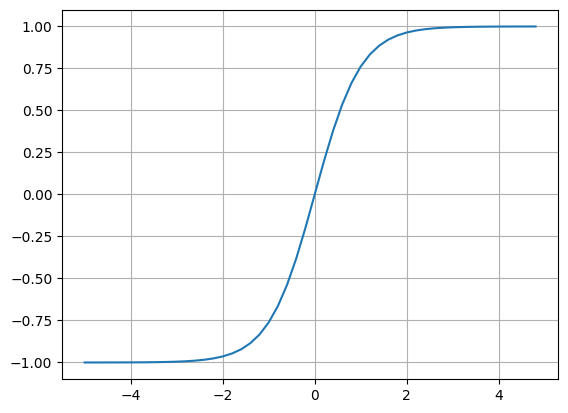

In [ ]:
## Plot TANH Activation function
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

# Linear Regression
:label:`sec_linear_regression`

*Regression* problems pop up whenever we want to predict a numerical value.
Common examples include predicting prices (of homes, stocks, etc.),
predicting the length of stay (for patients in the hospital),
forecasting demand (for retail sales), among numerous others.
Not every prediction problem is one of classical regression.
Later on, we will introduce classification problems,
where the goal is to predict membership among a set of categories.

## Basics

*Linear regression* is both the simplest
and most popular among the standard tools
for tackling regression problems.
Dating back to the dawn of the 19th century :cite:`Legendre.1805,Gauss.1809`,
linear regression flows from a few simple assumptions.
First, we assume that the relationship
between features $\mathbf{x}$ and target $y$
is approximately linear,
i.e., that the conditional mean $E[Y \mid X=\mathbf{x}]$
can be expressed as a weighted sum
of the features $\mathbf{x}$.
This setup allows that the target value
may still deviate from its expected value
on account of observation noise.
Next, we can impose the assumption that any such noise
is well behaved, following a Gaussian distribution.
Typically, we will use $n$ to denote
the number of examples in our dataset.
We use superscripts to enumerate samples and targets,
and subscripts to index coordinates.
More concretely,
$\mathbf{x}^{(i)}$ denotes the $i^{\textrm{th}}$ sample
and $x_j^{(i)}$ denotes its $j^{\textrm{th}}$ coordinate.

### Model
:label:`subsec_linear_model`

At the heart of every solution is a model
that describes how features can be transformed
into an estimate of the target.
The assumption of linearity means that
the expected value of the target (price) can be expressed
as a weighted sum of the features (area and age):

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

Here $w_{\textrm{area}}$ and $w_{\textrm{age}}$
are called *weights*, and $b$ is called a *bias*
(or *offset* or *intercept*).
The weights determine the influence of each feature on our prediction.
The bias determines the value of the estimate when all features are zero.
Even though we will never see any newly-built homes with precisely zero area,
we still need the bias because it allows us
to express all linear functions of our features
(rather than restricting us to lines that pass through the origin).
Strictly speaking, :eqref:`eq_price-area` is an *affine transformation* of input features, which is characterized by a *linear transformation* of features via a weighted sum, combined with a *translation* via the added bias.
Given a dataset, our goal is to choose
the weights $\mathbf{w}$ and the bias $b$
that, on average, make our model's predictions
fit the true prices observed in the data as closely as possible.


In disciplines where it is common to focus
on datasets with just a few features,
explicitly expressing models long-form,
as in :eqref:`eq_price-area`, is common.
In machine learning, we usually work
with high-dimensional datasets,
where it is more convenient to employ
compact linear algebra notation.
When our inputs consist of $d$ features,
we can assign each an index (between $1$ and $d$)
and express our prediction $\hat{y}$
(in general the "hat" symbol denotes an estimate) as

$$\hat{y} = w_1  x_1 + \cdots + w_d  x_d + b.$$

Collecting all features into a vector $\mathbf{x} \in \mathbb{R}^d$
and all weights into a vector $\mathbf{w} \in \mathbb{R}^d$,
we can express our model compactly via the dot product
between $\mathbf{w}$ and $\mathbf{x}$:

$$\hat{y} = \mathbf{w}^\top \mathbf{x} + b.$$
:eqlabel:`eq_linreg-y`

In :eqref:`eq_linreg-y`, the vector $\mathbf{x}$
corresponds to the features of a single example.
We will often find it convenient
to refer to features of our entire dataset of $n$ examples
via the *design matrix* $\mathbf{X} \in \mathbb{R}^{n \times d}$.
Here, $\mathbf{X}$ contains one row for every example
and one column for every feature.
For a collection of features $\mathbf{X}$,
the predictions $\hat{\mathbf{y}} \in \mathbb{R}^n$
can be expressed via the matrix--vector product:

$${\hat{\mathbf{y}}} = \mathbf{X} \mathbf{w} + b,$$
:eqlabel:`eq_linreg-y-vec`

where broadcasting (:numref:`subsec_broadcasting`) is applied during the summation.
Given features of a training dataset $\mathbf{X}$
and corresponding (known) labels $\mathbf{y}$,
the goal of linear regression is to find
the weight vector $\mathbf{w}$ and the bias term $b$
such that, given features of a new data example
sampled from the same distribution as $\mathbf{X}$,
the new example's label will (in expectation)
be predicted with the smallest error.

Even if we believe that the best model for
predicting $y$ given $\mathbf{x}$ is linear,
we would not expect to find a real-world dataset of $n$ examples where
$y^{(i)}$ exactly equals $\mathbf{w}^\top \mathbf{x}^{(i)}+b$
for all $1 \leq i \leq n$.
For example, whatever instruments we use to observe
the features $\mathbf{X}$ and labels $\mathbf{y}$, there might be a small amount of measurement error.
Thus, even when we are confident
that the underlying relationship is linear,
we will incorporate a noise term to account for such errors.

Before we can go about searching for the best *parameters*
(or *model parameters*) $\mathbf{w}$ and $b$,
we will need two more things:
(i) a measure of the quality of some given model;
and (ii) a procedure for updating the model to improve its quality.

### Loss Function
:label:`subsec_linear-regression-loss-function`

Naturally, fitting our model to the data requires
that we agree on some measure of *fitness*
(or, equivalently, of *unfitness*).
*Loss functions* quantify the distance
between the *real* and *predicted* values of the target.
The loss will usually be a nonnegative number
where smaller values are better
and perfect predictions incur a loss of 0.
For regression problems, the most common loss function is the squared error.
When our prediction for an example $i$ is $\hat{y}^{(i)}$
and the corresponding true label is $y^{(i)}$,
the *squared error* is given by:

$$l^{(i)}(\mathbf{w}, b) = \frac{1}{2} \left(\hat{y}^{(i)} - y^{(i)}\right)^2.$$
:eqlabel:`eq_mse`

The constant $\frac{1}{2}$ makes no real difference
but proves to be notationally convenient,
since it cancels out when we take the derivative of the loss.
Because the training dataset is given to us,
and thus is out of our control,
the empirical error is only a function of the model parameters.
In :numref:`fig_fit_linreg`, we visualize the fit of a linear regression model
in a problem with one-dimensional inputs.

![Fitting a linear regression model to one-dimensional data.](../img/fit-linreg.svg)
:label:`fig_fit_linreg`

Note that large differences between
estimates $\hat{y}^{(i)}$ and targets $y^{(i)}$
lead to even larger contributions to the loss,
due to its quadratic form
(this quadraticity can be a double-edge sword; while it encourages the model to avoid large errors
it can also lead to excessive sensitivity to anomalous data).
To measure the quality of a model on the entire dataset of $n$ examples,
we simply average (or equivalently, sum)
the losses on the training set:

$$L(\mathbf{w}, b) =\frac{1}{n}\sum_{i=1}^n l^{(i)}(\mathbf{w}, b) =\frac{1}{n} \sum_{i=1}^n \frac{1}{2}\left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)^2.$$

When training the model, we seek parameters ($\mathbf{w}^*, b^*$)
that minimize the total loss across all training examples:

$$\mathbf{w}^*, b^* = \operatorname*{argmin}_{\mathbf{w}, b}\  L(\mathbf{w}, b).$$

### Analytic Solution

Unlike most of the models that we will cover,
linear regression presents us with
a surprisingly easy optimization problem.
In particular, we can find the optimal parameters
(as assessed on the training data)
analytically by applying a simple formula as follows.
First, we can subsume the bias $b$ into the parameter $\mathbf{w}$
by appending a column to the design matrix consisting of all 1s.
Then our prediction problem is to minimize $\|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2$.
As long as the design matrix $\mathbf{X}$ has full rank
(no feature is linearly dependent on the others),
then there will be just one critical point on the loss surface
and it corresponds to the minimum of the loss over the entire domain.
Taking the derivative of the loss with respect to $\mathbf{w}$
and setting it equal to zero yields:

$$\begin{aligned}
    \partial_{\mathbf{w}} \|\mathbf{y} - \mathbf{X}\mathbf{w}\|^2 =
    2 \mathbf{X}^\top (\mathbf{X} \mathbf{w} - \mathbf{y}) = 0
    \textrm{ and hence }
    \mathbf{X}^\top \mathbf{y} = \mathbf{X}^\top \mathbf{X} \mathbf{w}.
\end{aligned}$$

Solving for $\mathbf{w}$ provides us with the optimal solution
for the optimization problem.
Note that this solution

$$\mathbf{w}^* = (\mathbf X^\top \mathbf X)^{-1}\mathbf X^\top \mathbf{y}$$

will only be unique
when the matrix $\mathbf X^\top \mathbf X$ is invertible,
i.e., when the columns of the design matrix
are linearly independent :cite:`Golub.Van-Loan.1996`.



While simple problems like linear regression
may admit analytic solutions,
you should not get used to such good fortune.
Although analytic solutions allow for nice mathematical analysis,
the requirement of an analytic solution is so restrictive
that it would exclude almost all exciting aspects of deep learning.

### Minibatch Stochastic Gradient Descent

Fortunately, even in cases where we cannot solve the models analytically,
we can still often train models effectively in practice.
Moreover, for many tasks, those hard-to-optimize models
turn out to be so much better that figuring out how to train them
ends up being well worth the trouble.

The key technique for optimizing nearly every deep learning model,
and which we will call upon throughout this book,
consists of iteratively reducing the error
by updating the parameters in the direction
that incrementally lowers the loss function.
This algorithm is called *gradient descent*.

The most naive application of gradient descent
consists of taking the derivative of the loss function,
which is an average of the losses computed
on every single example in the dataset.
In practice, this can be extremely slow:
we must pass over the entire dataset before making a single update,
even if the update steps might be very powerful :cite:`Liu.Nocedal.1989`.
Even worse, if there is a lot of redundancy in the training data,
the benefit of a full update is limited.

The other extreme is to consider only a single example at a time and to take
update steps based on one observation at a time.
The resulting algorithm, *stochastic gradient descent* (SGD)
can be an effective strategy :cite:`Bottou.2010`, even for large datasets.
Unfortunately, SGD has drawbacks, both computational and statistical.
One problem arises from the fact that processors are a lot faster
multiplying and adding numbers than they are
at moving data from main memory to processor cache.
It is up to an order of magnitude more efficient to
perform a matrix--vector multiplication
than a corresponding number of vector--vector operations.
This means that it can take a lot longer to process
one sample at a time compared to a full batch.
A second problem is that some of the layers,
such as batch normalization (to be described in :numref:`sec_batch_norm`),
only work well when we have access
to more than one observation at a time.

The solution to both problems is to pick an intermediate strategy:
rather than taking a full batch or only a single sample at a time,
we take a *minibatch* of observations :cite:`Li.Zhang.Chen.ea.2014`.
The specific choice of the size of the said minibatch depends on many factors,
such as the amount of memory, the number of accelerators,
the choice of layers, and the total dataset size.
Despite all that, a number between 32 and 256,
preferably a multiple of a large power of $2$, is a good start.
This leads us to *minibatch stochastic gradient descent*.

In its most basic form, in each iteration $t$,
we first randomly sample a minibatch $\mathcal{B}_t$
consisting of a fixed number $|\mathcal{B}|$ of training examples.
We then compute the derivative (gradient) of the average loss
on the minibatch with respect to the model parameters.
Finally, we multiply the gradient
by a predetermined small positive value $\eta$,
called the *learning rate*,
and subtract the resulting term from the current parameter values.
We can express the update as follows:

$$(\mathbf{w},b) \leftarrow (\mathbf{w},b) - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{(\mathbf{w},b)} l^{(i)}(\mathbf{w},b).$$

In summary, minibatch SGD proceeds as follows:
(i) initialize the values of the model parameters, typically at random;
(ii) iteratively sample random minibatches from the data,
updating the parameters in the direction of the negative gradient.
For quadratic losses and affine transformations,
this has a closed-form expansion:

$$\begin{aligned} \mathbf{w} & \leftarrow \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_{\mathbf{w}} l^{(i)}(\mathbf{w}, b) && = \mathbf{w} - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \mathbf{x}^{(i)} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right)\\ b &\leftarrow b -  \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \partial_b l^{(i)}(\mathbf{w}, b) &&  = b - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}_t} \left(\mathbf{w}^\top \mathbf{x}^{(i)} + b - y^{(i)}\right). \end{aligned}$$
:eqlabel:`eq_linreg_batch_update`

Since we pick a minibatch $\mathcal{B}$
we need to normalize by its size $|\mathcal{B}|$.
Frequently minibatch size and learning rate are user-defined.
Such tunable parameters that are not updated
in the training loop are called *hyperparameters*.
They can be tuned automatically by a number of techniques, such as Bayesian optimization
:cite:`Frazier.2018`. In the end, the quality of the solution is
typically assessed on a separate *validation dataset* (or *validation set*).

After training for some predetermined number of iterations
(or until some other stopping criterion is met),
we record the estimated model parameters,
denoted $\hat{\mathbf{w}}, \hat{b}$.
Note that even if our function is truly linear and noiseless,
these parameters will not be the exact minimizers of the loss, nor even deterministic.
Although the algorithm converges slowly towards the minimizers
it typically will not find them exactly in a finite number of steps.
Moreover, the minibatches $\mathcal{B}$
used for updating the parameters are chosen at random.
This breaks determinism.

Linear regression happens to be a learning problem
with a global minimum
(whenever $\mathbf{X}$ is full rank, or equivalently,
whenever $\mathbf{X}^\top \mathbf{X}$ is invertible).
However, the loss surfaces for deep networks contain many saddle points and minima.
Fortunately, we typically do not care about finding
an exact set of parameters but merely any set of parameters
that leads to accurate predictions (and thus low loss).
In practice, deep learning practitioners
seldom struggle to find parameters
that minimize the loss *on training sets*
:cite:`Izmailov.Podoprikhin.Garipov.ea.2018,Frankle.Carbin.2018`.
The more formidable task is to find parameters
that lead to accurate predictions on previously unseen data,
a challenge called *generalization*.
We return to these topics throughout the book.

### Predictions

Given the model $\hat{\mathbf{w}}^\top \mathbf{x} + \hat{b}$,
we can now make *predictions* for a new example,
e.g., predicting the sales price of a previously unseen house
given its area $x_1$ and age $x_2$.
Deep learning practitioners have taken to calling the prediction phase *inference*
but this is a bit of a misnomer---*inference* refers broadly
to any conclusion reached on the basis of evidence,
including both the values of the parameters
and the likely label for an unseen instance.
If anything, in the statistics literature
*inference* more often denotes parameter inference
and this overloading of terminology creates unnecessary confusion
when deep learning practitioners talk to statisticians.
In the following we will stick to *prediction* whenever possible.



## Vectorization for Speed

When training our models, we typically want to process
whole minibatches of examples simultaneously.
Doing this efficiently requires that (**we**) (~~should~~)
(**vectorize the calculations and leverage
fast linear algebra libraries
rather than writing costly for-loops in Python.**)

To see why this matters so much,
let's (**consider two methods for adding vectors.**)
To start, we instantiate two 10,000-dimensional vectors
containing all 1s.
In the first method, we loop over the vectors with a Python for-loop.
In the second, we rely on a single call to `+`.


Note that changing the mean corresponds
to a shift along the $x$-axis,
and increasing the variance
spreads the distribution out,
lowering its peak.

One way to motivate linear regression with squared loss
is to assume that observations arise from noisy measurements,
where the noise $\epsilon$ follows the normal distribution
$\mathcal{N}(0, \sigma^2)$:

$$y = \mathbf{w}^\top \mathbf{x} + b + \epsilon \textrm{ where } \epsilon \sim \mathcal{N}(0, \sigma^2).$$

Thus, we can now write out the *likelihood*
of seeing a particular $y$ for a given $\mathbf{x}$ via

$$P(y \mid \mathbf{x}) = \frac{1}{\sqrt{2 \pi \sigma^2}} \exp\left(-\frac{1}{2 \sigma^2} (y - \mathbf{w}^\top \mathbf{x} - b)^2\right).$$

As such, the likelihood factorizes.
According to *the principle of maximum likelihood*,
the best values of parameters $\mathbf{w}$ and $b$ are those
that maximize the *likelihood* of the entire dataset:

$$P(\mathbf y \mid \mathbf X) = \prod_{i=1}^{n} p(y^{(i)} \mid \mathbf{x}^{(i)}).$$

The equality follows since all pairs $(\mathbf{x}^{(i)}, y^{(i)})$
were drawn independently of each other.
Estimators chosen according to the principle of maximum likelihood
are called *maximum likelihood estimators*.
While, maximizing the product of many exponential functions,
might look difficult,
we can simplify things significantly, without changing the objective,
by maximizing the logarithm of the likelihood instead.
For historical reasons, optimizations are more often expressed
as minimization rather than maximization.
So, without changing anything,
we can *minimize* the *negative log-likelihood*,
which we can express as follows:

$$-\log P(\mathbf y \mid \mathbf X) = \sum_{i=1}^n \frac{1}{2} \log(2 \pi \sigma^2) + \frac{1}{2 \sigma^2} \left(y^{(i)} - \mathbf{w}^\top \mathbf{x}^{(i)} - b\right)^2.$$

If we assume that $\sigma$ is fixed,
we can ignore the first term,
because it does not depend on $\mathbf{w}$ or $b$.
The second term is identical
to the squared error loss introduced earlier,
except for the multiplicative constant $\frac{1}{\sigma^2}$.
Fortunately, the solution does not depend on $\sigma$ either.
It follows that minimizing the mean squared error
is equivalent to the maximum likelihood estimation
of a linear model under the assumption of additive Gaussian noise.


## Linear Regression as a Neural Network

While linear models are not sufficiently rich
to express the many complicated networks
that we will introduce in this book,
(artificial) neural networks are rich enough
to subsume linear models as networks
in which every feature is represented by an input neuron,
all of which are connected directly to the output.

:numref:`fig_single_neuron` depicts
linear regression as a neural network.
The diagram highlights the connectivity pattern,
such as how each input is connected to the output,
but not the specific values taken by the weights or biases.

![Linear regression is a single-layer neural network.](http://d2l.ai/_images/singleneuron.svg)
:label:`fig_single_neuron`

The inputs are $x_1, \ldots, x_d$.
We refer to $d$ as the *number of inputs*
or the *feature dimensionality* in the input layer.
The output of the network is $o_1$.
Because we are just trying to predict
a single numerical value,
we have only one output neuron.
Note that the input values are all *given*.
There is just a single *computed* neuron.
In summary, we can think of linear regression
as a single-layer fully connected neural network.
We will encounter networks
with far more layers
in later chapters.

### Biology

Because linear regression predates computational neuroscience,
it might seem anachronistic to describe
linear regression in terms of neural networks.
Nonetheless, they were a natural place to start
when the cyberneticists and neurophysiologists
Warren McCulloch and Walter Pitts began to develop
models of artificial neurons.
Consider the cartoonish picture
of a biological neuron in :numref:`fig_Neuron`,
consisting of *dendrites* (input terminals),
the *nucleus* (CPU), the *axon* (output wire),
and the *axon terminals* (output terminals),
enabling connections to other neurons via *synapses*.

![The real neuron (source: "Anatomy and Physiology" by the US National Cancer Institute's Surveillance, Epidemiology and End Results (SEER) Program).](http://d2l.ai/_images/neuron.svg)
:label:`fig_Neuron`

Information $x_i$ arriving from other neurons
(or environmental sensors) is received in the dendrites.
In particular, that information is weighted
by *synaptic weights* $w_i$,
determining the effect of the inputs,
e.g., activation or inhibition via the product $x_i w_i$.
The weighted inputs arriving from multiple sources
are aggregated in the nucleus
as a weighted sum $y = \sum_i x_i w_i + b$,
possibly subject to some nonlinear postprocessing via a function $\sigma(y)$.
This information is then sent via the axon to the axon terminals,
where it reaches its destination
(e.g., an actuator such as a muscle)
or it is fed into another neuron via its dendrites.

Certainly, the high-level idea that many such units
could be combined, provided they have the correct connectivity and learning algorithm,
to produce far more interesting and complex behavior
than any one neuron alone could express
arises from our study of real biological neural systems.
At the same time, most research in deep learning today
draws inspiration from a much wider source.
We invoke :citet:`Russell.Norvig.2016`
who pointed out that although airplanes might have been *inspired* by birds,
ornithology has not been the primary driver
of aeronautics innovation for some centuries.
Likewise, inspiration in deep learning these days
comes in equal or greater measure
from mathematics, linguistics, psychology,
statistics, computer science, and many other fields.



## Let's Build Linear Regression Model

$$\textrm{price} = w_{\textrm{area}} \cdot \textrm{area} + w_{\textrm{age}} \cdot \textrm{age} + b.$$
:eqlabel:`eq_price-area`

$$\hat{y} = w_1  x_1 + w_2  x_2  + w_d  x_d + b.$$

In [ ]:
# inputs x1,x2
x1 = Data(2.0, label='x1')
x2 = Data(0.0, label='x2')
# weights w1,w2
w1 = Data(-3.0, label='w1')
w2 = Data(1.0, label='w2')
# bias of the neuron
b = Data(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
y = x1w1x2w2 + b; y.label = 'y'

In [ ]:
# visualized L graph now
viz_Y = visualize_computational_graph(y)
# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.title("Visualized Y Graph ")
plt.axis('off')
plt.imshow(viz_Y)
plt.show()

In [ ]:
# Andrej Karpathy work by diffrent method , he use topological sorting
# Like this

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._children:
      build_topo(child)
    topo.append(v)
build_topo(y)
topo

[Data(data=0.0),
 Data(data=1.0),
 Data(data=0.0),
 Data(data=-3.0),
 Data(data=2.0),
 Data(data=-6.0),
 Data(data=-6.0),
 Data(data=6.881373587019543),
 Data(data=0.8813735870195432)]

In [ ]:
y.grad = 1.0
y._backward()

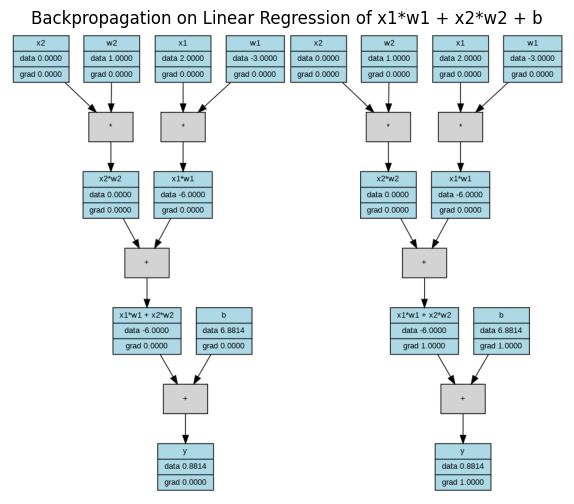

In [ ]:
viz_back_y = visualize_computational_graph(y) # visualized final grad of all object

# Concatenate the images horizontally
concatenated_image = concatenate_images(viz_Y, viz_back_y, axis='horizontal')


# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.title("Backpropagation on Linear Regression of x1*w1 + x2*w2 + b")
plt.axis('off')
plt.imshow(concatenated_image)
plt.show()

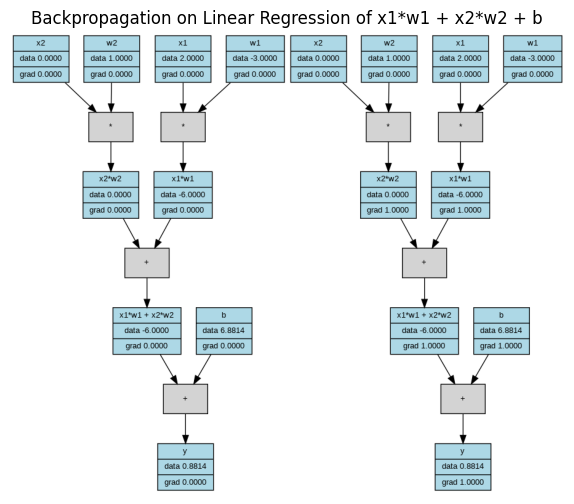

In [ ]:
x1w1x2w2._backward()
viz_back_y = visualize_computational_graph(y) # visualized final grad of all object

# Concatenate the images horizontally
concatenated_image = concatenate_images(viz_Y, viz_back_y, axis='horizontal')


# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.title("Backpropagation on Linear Regression of x1*w1 + x2*w2 + b")
plt.axis('off')
plt.imshow(concatenated_image)
plt.show()

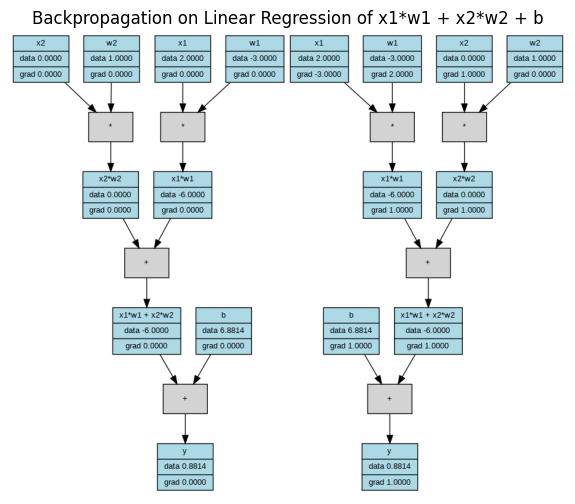

In [ ]:
Data.backward(y)
viz_back_y = visualize_computational_graph(y) # visualized final grad of all object

# Concatenate the images horizontally
concatenated_image = concatenate_images(viz_Y, viz_back_y, axis='horizontal')


# Plot the function and its derivative
plt.figure(figsize=(8, 6))
plt.title("Backpropagation on Linear Regression of x1*w1 + x2*w2 + b")
plt.axis('off')
plt.imshow(concatenated_image)
plt.show()

## Neural Network (Linear Reg + Activation Function)

In [ ]:
# inputs x1,x2
x1 = Data(2.0, label='x1')
x2 = Data(0.0, label='x2')
# weights w1,w2
w1 = Data(-3.0, label='w1')
w2 = Data(1.0, label='w2')
# bias of the neuron
b = Data(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

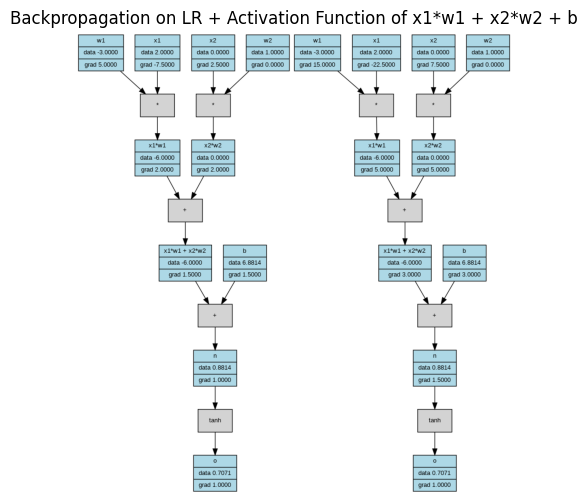

In [ ]:
viz_o = visualize_computational_graph(o) # visualized final grad of all object
Data.backward(o)
viz_back_o = visualize_computational_graph(o) # visualized final grad of all object

# Concatenate the images horizontally
concatenated_image = concatenate_images(viz_o , viz_back_o, axis='horizontal')


# Plot the function and its derivative
plt.figure(figsize=(12, 6))
plt.title("Backpropagation on LR + Activation Function of x1*w1 + x2*w2 + b")
plt.axis('off')
plt.imshow(concatenated_image)
plt.show()

## How to Implement this code using Framework

In [ ]:
import tensorflow as tf

x1 = tf.Variable([2.0], dtype=tf.float64)
x2 = tf.Variable([0.0], dtype=tf.float64)
w1 = tf.Variable([-3.0], dtype=tf.float64)
w2 = tf.Variable([1.0], dtype=tf.float64)
b = tf.Variable([6.8813735870195432], dtype=tf.float64)

with tf.GradientTape() as tape:
    n = x1 * w1 + x2 * w2 + b
    o = tf.math.tanh(n)
    loss = tf.reduce_sum(o)  # Dummy loss for demonstration

gradients = tape.gradient(loss, [x1, x2, w1, w2, b])

print(o.numpy().item())
print('---')
print('x2', gradients[1].numpy().item())
print('w2', gradients[3].numpy().item())
print('x1', gradients[0].numpy().item())
print('w1', gradients[2].numpy().item())

0.7071067811865477
---
x2 0.4999999999999998
w2 0.0
x1 -1.4999999999999993
w1 0.9999999999999996


# For Torch